## 모듈 임포트

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## 모델 입력 차원
- 모델의 입력과 데이터셋의 차원 지정
- MNIST는 하나의 채널(흑백 이미지)을 가진 28x28 픽셀의 이미지

In [10]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)   # 입력 이미지 차원

z_dim = 100   # 생성자의 입력으로 사용될 잡음 벡터의 크기

## 생성자
- 간단하게 만들기 위해: 생성자 네트워크는 하나의 은닉층 가지기
- z벡터를 입력받아 28x28x1 크기 이미지 생성
- 은닉층은 LeakyReLU 활성화 함수 사용 (alpha=음수일때 기울기) -> gradient소실방지
- 출력층은 tanh활성화 함수 사용 (sigmoid보다 또렷한 이미지 출력)

In [11]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))   # 완전 연결층
    model.add(LeakyReLU(alpha=0.01))    # LeakyReLU 활성화 함수
    model.add(Dense(28*28*1, activation='tanh'))    # tanh 활성화 함수를 사용한 출력층
    model.add(Reshape(img_shape))    # 생성자 출력을 이미지 차원으로 변경
    return model

## 판별자
- 28x28x1 크기의 이미지를 받아 가짜와 비교해 얼마나 진짜인지를 나타내는 확률을 출력
- 2개의 층으로 가진 네트워크
- 출력층은 sigmoid를 사용해 판별자가 입력을 진짜로 생각하는 확률 (sigmoid:0에서1출력)

In [12]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))    # 입력 이미지를 일렬로 펼치기
    model.add(Dense(128))    # 완전 연결층
    model.add(LeakyReLU(alpha=0.01))    # LeakyReLU 활성화 함수
    model.add(Dense(1, activation='sigmoid'))    # 시그모이드 활성화 함수를 사용한 출력층
    return model

## GAN 모델 만들기와 컴파일
- discriminator.trainable=False: 생성자는 훈련하고 판별자를 훈련하지 않도록 설정, 판별자는 독립적으로 컴파일된 모델로 훈련
- binary_crossentropy(이진 교차 엔트로피): 훈련하는 동안 최소화할 손실함수 (손실 클수록 예측이 정답 레이블과 차이가 큼)

In [13]:
def build_gan(generator, discriminator):
    model = Sequential()
    # 생성자+판별자 모델 연결
    model.add(generator)
    model.add(discriminator)
    return model

# 판별자 모델 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim)

# 생성자 훈련할 때 판별자 파라미터 동결하기
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결한 판별자로 GAN 모델 만들고 컴파일하기
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [20]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (x_train, _), (_, _) = mnist.load_data()    # MNIST 데이터 로드
    
    # [0,255]흑백픽셀값을 [-1,1]사이로 스케일 조정
    x_train = x_train/127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))    # 진짜 이미지 레이블: 모두 1
    fake = np.zeros((batch_size, 1))   # 가짜 이미지 레이블: 모두 0
    
    for iter in range(iterations):
        
        
        ## 판별자 훈련 ##
        
        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5*np.add(d_loss_real, d_loss_fake)
        
        
        ## 생성자 훈련 ##
        
        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)
        
        if (iter+1) % sample_interval == 0:
            
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iteration_checkpoints.append(iter+1)
            
            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %(iter+1, d_loss, 100.0*accuracy, g_loss))
            
            # 생성된 이미지 샘플 출력
            sample_images(generator)

## 생성된 이미지 출력
- sample_interval 반복 동안 호출하여 생성자가 합성한 4x4이미지 그리드 출력

In [21]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    z = np.random.normal(0, 1, (image_grid_rows*image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5*gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                            figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## 모델 실행

1000 [D 손실: 0.035606, 정확도: 99.22%] [G 손실: 4.822439]
2000 [D 손실: 0.184702, 정확도: 90.62%] [G 손실: 4.341623]
3000 [D 손실: 0.236133, 정확도: 90.62%] [G 손실: 3.663969]
4000 [D 손실: 0.216602, 정확도: 91.41%] [G 손실: 4.290146]
5000 [D 손실: 0.157182, 정확도: 93.75%] [G 손실: 5.186251]
6000 [D 손실: 0.175436, 정확도: 91.80%] [G 손실: 4.295248]
7000 [D 손실: 0.450960, 정확도: 81.25%] [G 손실: 3.108053]
8000 [D 손실: 0.284362, 정확도: 87.11%] [G 손실: 3.854790]
9000 [D 손실: 0.276470, 정확도: 88.67%] [G 손실: 3.844755]
10000 [D 손실: 0.478953, 정확도: 81.25%] [G 손실: 3.458115]
11000 [D 손실: 0.266921, 정확도: 89.06%] [G 손실: 3.478294]
12000 [D 손실: 0.326371, 정확도: 87.11%] [G 손실: 3.287089]
13000 [D 손실: 0.315806, 정확도: 86.72%] [G 손실: 3.674469]
14000 [D 손실: 0.225957, 정확도: 90.23%] [G 손실: 3.326653]
15000 [D 손실: 0.397758, 정확도: 82.42%] [G 손실: 2.826214]
16000 [D 손실: 0.364444, 정확도: 85.94%] [G 손실: 3.077775]
17000 [D 손실: 0.294595, 정확도: 87.50%] [G 손실: 3.224726]
18000 [D 손실: 0.351596, 정확도: 83.98%] [G 손실: 2.894152]
19000 [D 손실: 0.275832, 정확도: 87.89%] [G 손실: 3.185325]
20

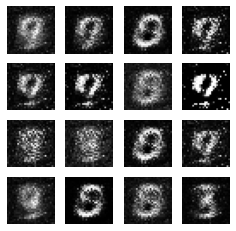

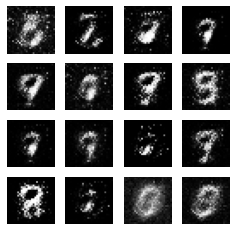

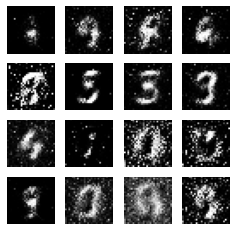

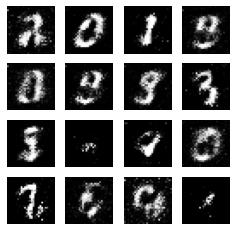

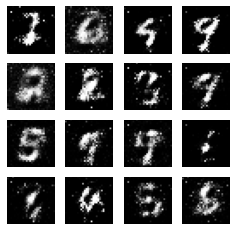

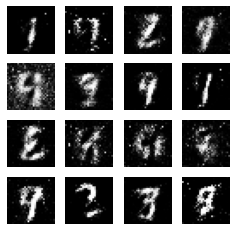

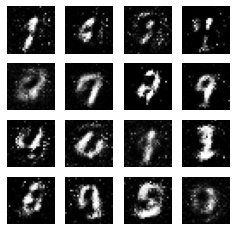

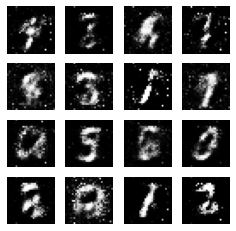

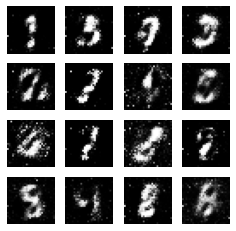

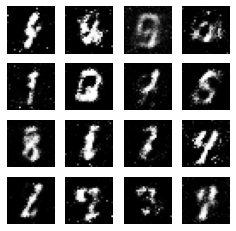

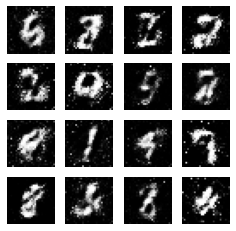

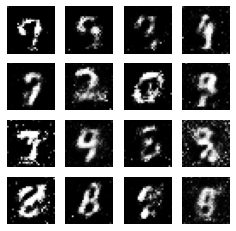

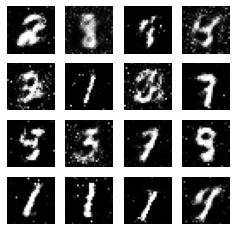

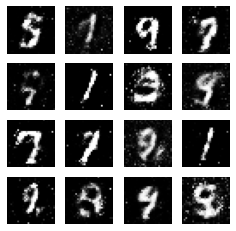

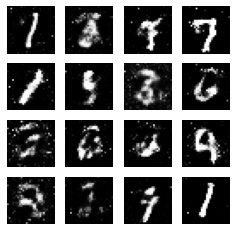

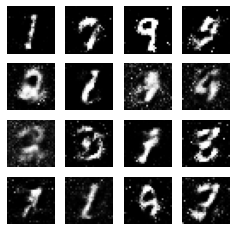

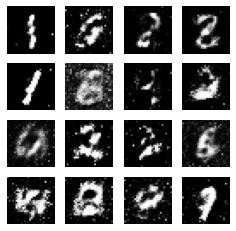

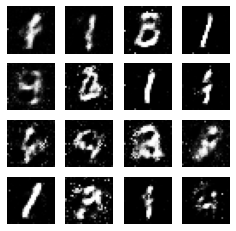

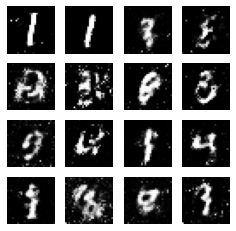

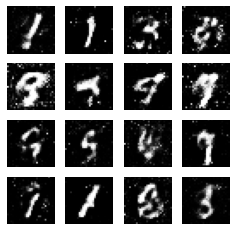

In [22]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 횟수 동안 GAN 훈련
train(iterations, batch_size, sample_interval)